# Multi Label Classification: Auto Tagging

Importing required Libraries

In [1]:
import re

import joblib
import nltk
import pandas as pd
import seaborn as sns
import spacy
from matplotlib import pyplot as plt
from nltk import WordNetLemmatizer, word_tokenize, FreqDist
from nltk.corpus import stopwords
from sklearn.ensemble import RandomForestClassifier, VotingClassifier
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import SGDClassifier, LogisticRegression
from sklearn.metrics import jaccard_score
from sklearn.model_selection import train_test_split
from sklearn.multiclass import OneVsRestClassifier
from sklearn.preprocessing import MultiLabelBinarizer
from sklearn.svm import LinearSVC, SVC
from xgboost import XGBClassifier

Loading Dataset

In [2]:
dataset = pd.read_excel('Sample_AutoTagging_Data_Confidential.xlsx')
dataset.head()

,SUMMARY,PRACTICE/AREA,SL/SUB-AREA
0,Climate risk and response: Physical hazards an...,Risk & Resilience|Strategy & Corporate Finance...,Sustainability - Climate & ESG Mgmt|Government...
1,New Accenture Research Finds Leaders and Emplo...,Organization,Talent|Culture & transformational change
2,"Me, my life, my wallet - The widespread and im...","Growth, Marketing & Sales",Customer experience
3,The next normal arrives: Trends that will defi...,Public And Social Sector|Risk & Resilience|Gro...,Economic development|Crisis Preparedness and R...
4,Our 2021 technology predictions for businesses...,McKinsey Technology|Organization,Tech strategy & operating model & agile|Leader...


Dataset Information

In [3]:
dataset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20000 entries, 0 to 19999
Data columns (total 3 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   SUMMARY        20000 non-null  object
 1   PRACTICE/AREA  20000 non-null  object
 2   SL/SUB-AREA    20000 non-null  object
dtypes: object(3)
memory usage: 468.9+ KB


Dataset Statistics

In [4]:
dataset.describe()

,SUMMARY,PRACTICE/AREA,SL/SUB-AREA
count,20000,20000,20000
unique,19985,5910,12637
top,Survey: US consumer sentiment during the coron...,Organization,Economic development
freq,3,1034,347


### Data-Preprocessing

In [5]:
nltk.download('punkt')
nltk.download('wordnet')
nltk.download('stopwords')

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\Rituraj.Raman\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\Rituraj.Raman\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Rituraj.Raman\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [6]:
lemmatizer = WordNetLemmatizer()


def preprocess_text(document):
    # Lower case
    document = document.lower()

    # Remove punctuation and numbers
    document = re.sub(r'[^\w\s]', '', document)
    document = re.sub(r'\d+', '', document)

    # Tokenize
    tokens = word_tokenize(document)

    # Remove duplicate words
    tokens = list(set(tokens))

    # Remove stopwords, Lemmatize, and then rejoin the words
    wordsLemmatized = [lemmatizer.lemmatize(word) for word in tokens if word not in set(stopwords.words('english'))]
    document = " ".join(wordsLemmatized)
    return document

In [7]:
dataset['SUMMARY'] = dataset['SUMMARY'].apply(preprocess_text)
dataset.head()

,SUMMARY,PRACTICE/AREA,SL/SUB-AREA
0,particular study supply qualitatively hazard c...,Risk & Resilience|Strategy & Corporate Finance...,Sustainability - Climate & ESG Mgmt|Government...
1,environment higher enables hidden increase clo...,Organization,Talent|Culture & transformational change
2,adjust supply marketplace chain operated chang...,"Growth, Marketing & Sales",Customer experience
3,scrambling train normal next fight pandemic mo...,Public And Social Sector|Risk & Resilience|Gro...,Economic development|Crisis Preparedness and R...
4,changewill behavior clear global new expectati...,McKinsey Technology|Organization,Tech strategy & operating model & agile|Leader...


In [31]:
nlp = spacy.load('en_core_web_sm')


def preprocess_spacy(text):
    doc = nlp(text)
    return " ".join([token.lemma_ for token in doc if not token.is_stop])

OSError: [E050] Can't find model 'en_core_web_sm'. It doesn't seem to be a Python package or a valid path to a data directory.

In [32]:
dataset['SUMMARY'] = dataset['SUMMARY'].apply(preprocess_spacy)
dataset.head()

NameError: name 'preprocess_spacy' is not defined

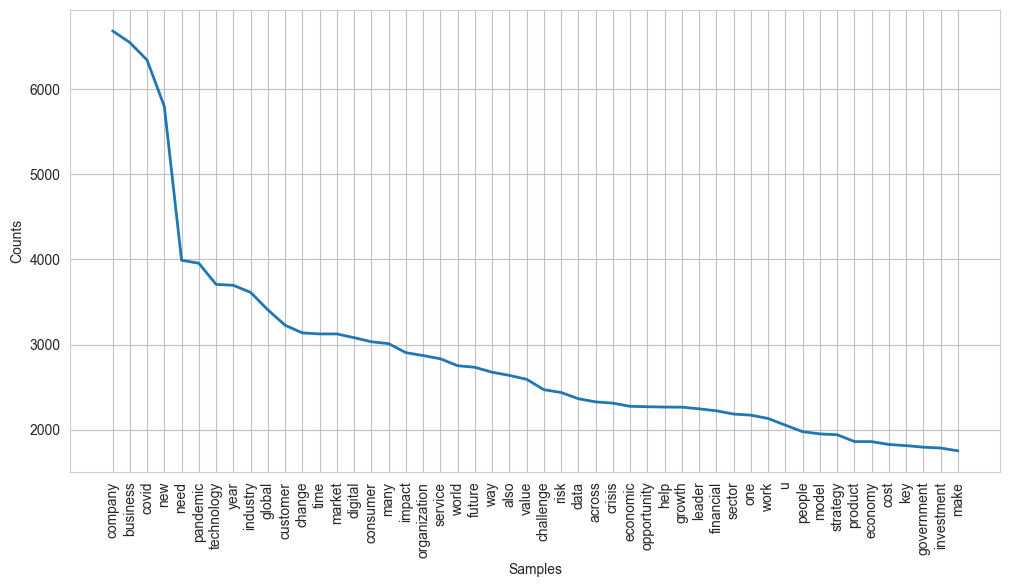

Total Words Count:  934603


In [8]:
corpus = ' '.join(dataset['SUMMARY'])

tokens = nltk.word_tokenize(corpus)

fdist = FreqDist(tokens)

plt.figure(figsize=(12, 6))
fdist.plot(50, cumulative=False)
plt.show()
print('Total Words Count: ', len(tokens))

In [9]:
dataset['PRACTICE/AREA'] = dataset['PRACTICE/AREA'].str.split('|')
dataset['SL/SUB-AREA'] = dataset['SL/SUB-AREA'].str.split('|')
dataset.head()

,SUMMARY,PRACTICE/AREA,SL/SUB-AREA
0,particular study supply qualitatively hazard c...,"[Risk & Resilience, Strategy & Corporate Finan...","[Sustainability - Climate & ESG Mgmt, Governme..."
1,environment higher enables hidden increase clo...,[Organization],"[Talent, Culture & transformational change]"
2,adjust supply marketplace chain operated chang...,"[Growth, Marketing & Sales]",[Customer experience]
3,scrambling train normal next fight pandemic mo...,"[Public And Social Sector, Risk & Resilience, ...","[Economic development, Crisis Preparedness and..."
4,changewill behavior clear global new expectati...,"[McKinsey Technology, Organization]","[Tech strategy & operating model & agile, Lead..."


In [35]:
mlb = MultiLabelBinarizer()
binarizedLabels1 = mlb.fit_transform(dataset['PRACTICE/AREA'])
binarizedLabels1 = pd.DataFrame(binarizedLabels1, columns=mlb.classes_)
binarizedLabels1.head()

,Advanced Electronics,Aerospace & Defense,Agriculture,Automotive,Banking,Basic Materials,Business & Consumer Services,Chemicals,Consumer Goods,Digital & Analytics (DnA),...,Private Equity,Public And Social Sector,Public and Social Sector,Retail,Risk & Resilience,Risk & resilience,Strategy & Corporate Finance,Sustainability,"Telecom, Media & Technology","Travel, Logistics & Infrastructure"
0,0,0,1,0,0,0,0,0,0,0,...,0,0,0,0,1,0,1,1,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,1,...,0,1,0,1,1,0,1,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [36]:
dataset = pd.concat([dataset, binarizedLabels1], axis=1)
dataset.drop('PRACTICE/AREA', axis=1, inplace=True)
dataset.head()

,SUMMARY,SL/SUB-AREA,Advanced Electronics,Aerospace & Defense,Agriculture,Automotive,Banking,Basic Materials,Business & Consumer Services,Chemicals,...,Private Equity,Public And Social Sector,Public and Social Sector,Retail,Risk & Resilience,Risk & resilience,Strategy & Corporate Finance,Sustainability,"Telecom, Media & Technology","Travel, Logistics & Infrastructure"
0,global human localized flooding help physical ...,"[Sustainability - Climate & ESG Mgmt, Governme...",0,0,1,0,0,0,0,0,...,0,0,0,0,1,0,1,1,0,0
1,global would differing organization building e...,"[Talent, Culture & transformational change]",0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,engaged partner brought business forced custom...,[Customer experience],0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,pandemic past tunnelalong least end arrives tr...,"[Economic development, Crisis Preparedness and...",0,0,0,0,0,0,0,0,...,0,1,0,1,1,0,1,0,0,0
4,global pandemic changewill across future pivot...,"[Tech strategy & operating model & agile, Lead...",0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


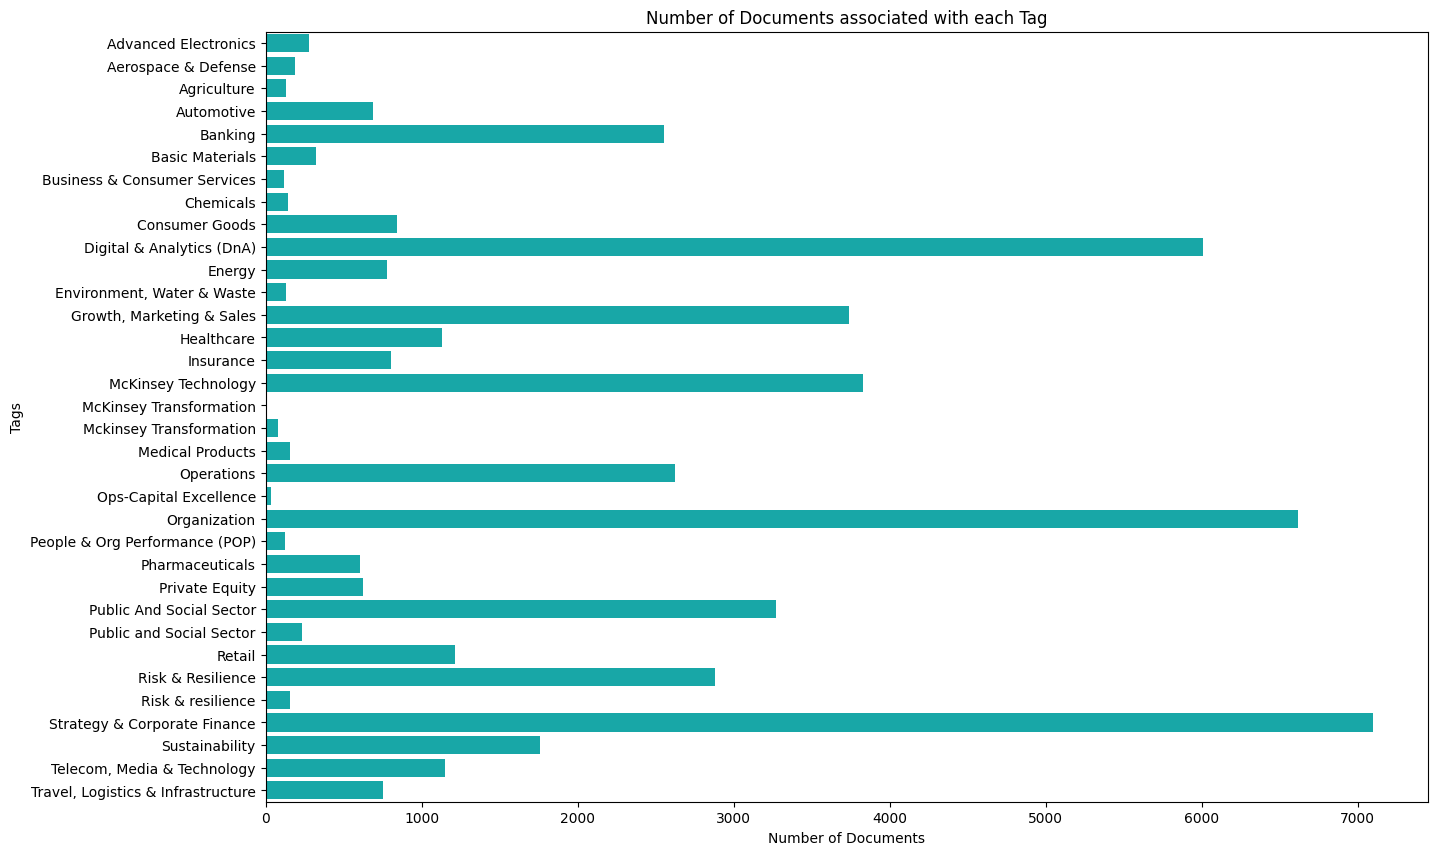

In [37]:
tag_counts = binarizedLabels1.sum(numeric_only=True)

# Plot
plt.figure(figsize=(15, 10))
sns.barplot(x=tag_counts.values, y=tag_counts.index, color='c')
plt.xlabel('Number of Documents')
plt.ylabel('Tags')
plt.title('Number of Documents associated with each Tag')
plt.show()

In [85]:
X_train_1, X_test_1, y_train_1, y_test_1 = train_test_split(dataset['SUMMARY'], binarizedLabels1, test_size=0.1,
                                                            random_state=41)

In [39]:
tfidf = TfidfVectorizer(ngram_range=(1, 2), stop_words='english')
X_train_tfidf_1 = tfidf.fit_transform(X_train_1)
X_test_tfidf_1 = tfidf.transform(X_test_1)
X_train_tfidf_1.shape, X_test_tfidf_1.shape

((18000, 507764), (2000, 507764))

In [40]:
RFC_1 = OneVsRestClassifier(RandomForestClassifier())
rfc1 = RFC_1.fit(X_train_tfidf_1, y_train_1)

In [41]:
SGD_1 = OneVsRestClassifier(SGDClassifier())
sgd1 = SGD_1.fit(X_train_tfidf_1, y_train_1)

In [42]:
LR_1 = OneVsRestClassifier(LogisticRegression(solver='lbfgs'))
lr1 = LR_1.fit(X_train_tfidf_1, y_train_1)

In [43]:
SVC_1 = OneVsRestClassifier(LinearSVC())
svc1 = SVC_1.fit(X_train_tfidf_1, y_train_1)

In [44]:
XGB_1 = OneVsRestClassifier(XGBClassifier())
xgb1 = XGB_1.fit(X_train_tfidf_1, y_train_1)

In [46]:
log_clf = LogisticRegression(solver='liblinear')
rnd_clf = RandomForestClassifier(n_estimators=100)
xgb_clf = XGBClassifier(n_estimators=100)
svm_clf = SVC(gamma='auto', probability=True)
voting_clf = VotingClassifier(
    estimators=[('lr', log_clf), ('rf', rnd_clf), ('svc', svm_clf), ('xgb', xgb_clf)], voting='hard')
ovr_voting_1 = OneVsRestClassifier(voting_clf)
ovr_voting_1.fit(X_train_tfidf_1, y_train_1)

KeyboardInterrupt: 

In [17]:
def jaccard_scr(y_true, y_pred, average_option='samples'):
    return jaccard_score(y_true, y_pred, average=average_option) * 100

In [56]:
models = [
    ('RandomForest', rfc1),
    ('SGD', sgd1),
    ('LogisticRegression', lr1),
    ('LinearSVC', svc1),
    ('XGBoost', xgb1),
    # ('VotingClassifier', ovr_voting_1)
]

model_comparison = {}

for model_name, model in models:
    predictions = model.predict(X_test_tfidf_1)
    jaccard = jaccard_scr(y_test_1, predictions)

    model_comparison.update({model_name: jaccard})
    joblib.dump(model, model_name + '.joblib')

model_score = pd.DataFrame(model_comparison.items(), columns=['Model', 'Jaccard Score'])

model_score

,Model,Jaccard Score
0,RandomForest,29.907500
1,SGD,42.877321
2,LogisticRegression,35.977440
3,LinearSVC,49.643631
4,XGBoost,49.045476


In [81]:
text = [
    'Understanding mobility’s second great inflection point - Senior partner Asutosh Padhi discusses the technological breakthroughs changing the mobility ecosystem and lays out what the shifts mean for automotive and other industries.']
text = pd.Series(text)
text = text.apply(preprocess_text)
text_tfidf = tfidf.transform(text)
predictions = svc1.predict(text_tfidf)
predicted_labels = mlb.inverse_transform(predictions)
predicted_labels

[('Automotive', 'Insurance', 'Organization', 'Strategy & Corporate Finance')]

In [ ]:
model = joblib.load('LinearSVC.joblib')

In [86]:
for i in X_test_1:
    text = pd.Series(i)
    text = text.apply(preprocess_text)
    text_tfidf = tfidf.transform(text)
    predictions = model.predict(text_tfidf)
    predicted_labels = mlb.inverse_transform(predictions)
    print(predicted_labels)

[('Digital & Analytics (DnA)', 'Public And Social Sector', 'Sustainability')]
[('Sustainability',)]
[('Consumer Goods', 'Growth, Marketing & Sales', 'Strategy & Corporate Finance')]
[('Healthcare', 'Strategy & Corporate Finance')]
[('Digital & Analytics (DnA)', 'McKinsey Technology', 'Public And Social Sector')]
[('Operations', 'Strategy & Corporate Finance')]
[('Digital & Analytics (DnA)', 'Private Equity', 'Public And Social Sector', 'Strategy & Corporate Finance')]
[('Banking', 'Digital & Analytics (DnA)', 'Public And Social Sector')]
[('Risk & Resilience',)]
[('Digital & Analytics (DnA)', 'Growth, Marketing & Sales', 'Insurance', 'Strategy & Corporate Finance')]
[('Digital & Analytics (DnA)', 'Organization')]
[('Consumer Goods', 'Digital & Analytics (DnA)')]
[('Digital & Analytics (DnA)', 'Energy', 'McKinsey Technology')]
[('Digital & Analytics (DnA)', 'Public And Social Sector')]
[('Growth, Marketing & Sales', 'Telecom, Media & Technology')]
[('Digital & Analytics (DnA)', 'Strateg

In [89]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Activation

In [90]:
num_features = X_train_tfidf_1.shape[1]
num_classes = y_train_1.shape[1]
num_features, num_classes

(507764, 34)

In [91]:
# Build the model
model = Sequential()

model.add(Dense(256, input_shape=(num_features,)))
model.add(Activation('relu'))
model.add(Dropout(0.5))
model.add(Dense(128))
model.add(Activation('relu'))
model.add(Dropout(0.5))
model.add(Dense(64))
model.add(Activation('relu'))
model.add(Dropout(0.5))

model.add(Dense(num_classes))
model.add(Activation('sigmoid'))

C:\Users\Rituraj.Raman\Desktop\AIRA Project\AutoTagger\venv\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [92]:
# Compile the model
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

In [ ]:
# Train the model
model.fit(X_train_tfidf_1, y_train_1, epochs=50, batch_size=32, validation_split=0.2)

Epoch 1/50


C:\Users\Rituraj.Raman\Desktop\AIRA Project\AutoTagger\venv\Lib\site-packages\tensorflow\python\framework\indexed_slices.py:446: UserWarning: Converting sparse IndexedSlices to a dense Tensor with 129987584 elements. This may consume a large amount of memory.
  warnings.warn(


450/450 ━━━━━━━━━━━━━━━━━━━━ 401s 886ms/step - accuracy: 0.0736 - loss: 0.3542 - val_accuracy: 0.0417 - val_loss: 0.2127
Epoch 2/50
450/450 ━━━━━━━━━━━━━━━━━━━━ 383s 852ms/step - accuracy: 0.0980 - loss: 0.2153 - val_accuracy: 0.0969 - val_loss: 0.2135
Epoch 3/50
450/450 ━━━━━━━━━━━━━━━━━━━━ 385s 855ms/step - accuracy: 0.1104 - loss: 0.2050 - val_accuracy: 0.0667 - val_loss: 0.2163
Epoch 4/50
450/450 ━━━━━━━━━━━━━━━━━━━━ 383s 851ms/step - accuracy: 0.1832 - loss: 0.1906 - val_accuracy: 0.1017 - val_loss: 0.2253
Epoch 5/50
450/450 ━━━━━━━━━━━━━━━━━━━━ 384s 854ms/step - accuracy: 0.2656 - loss: 0.1721 - val_accuracy: 0.0950 - val_loss: 0.2355
Epoch 6/50
450/450 ━━━━━━━━━━━━━━━━━━━━ 431s 958ms/step - accuracy: 0.3350 - loss: 0.1574 - val_accuracy: 0.1161 - val_loss: 0.2413
Epoch 7/50
450/450 ━━━━━━━━━━━━━━━━━━━━ 488s 1s/step - accuracy: 0.3635 - loss: 0.1474 - val_accuracy: 0.1067 - val_loss: 0.2481
Epoch 8/50
450/450 ━━━━━━━━━━━━━━━━━━━━ 486s 1s/step - accuracy: 0.3594 - loss: 0.1410 - v

In [ ]:
# Save the Model
model.save('nnmodel.h5')

In [10]:
mlb = MultiLabelBinarizer()
binarizedLabels2 = mlb.fit_transform(dataset['SL/SUB-AREA'])
binarizedLabels2 = pd.DataFrame(binarizedLabels2, columns=mlb.classes_)
binarizedLabels2.head()

,Accounting services,Advanced Electronics- Other,Advanced materials,Aerospace & Defense- Other,Aerospace aftermarket & services,Aerospace equipment & products,Aftermarket & services,Agricultural inputs,Agricultural produce trading & processing,Agriculture input distribution & service,...,"Travel, Logistics & Infrastructure- Other",Underwriting,Venture Capital,Venture capital,Water,Wealth & asset management,Wealth and asset management,consumer electronics,food,talent
0,0,0,0,0,0,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [11]:
dataset = pd.concat([dataset, binarizedLabels2], axis=1)
dataset.drop('PRACTICE/AREA', axis=1, inplace=True)
dataset.head()

,SUMMARY,SL/SUB-AREA,Accounting services,Advanced Electronics- Other,Advanced materials,Aerospace & Defense- Other,Aerospace aftermarket & services,Aerospace equipment & products,Aftermarket & services,Agricultural inputs,...,"Travel, Logistics & Infrastructure- Other",Underwriting,Venture Capital,Venture capital,Water,Wealth & asset management,Wealth and asset management,consumer electronics,food,talent
0,particular study supply qualitatively hazard c...,"[Sustainability - Climate & ESG Mgmt, Governme...",0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,environment higher enables hidden increase clo...,"[Talent, Culture & transformational change]",0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,adjust supply marketplace chain operated chang...,[Customer experience],0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,scrambling train normal next fight pandemic mo...,"[Economic development, Crisis Preparedness and...",0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,changewill behavior clear global new expectati...,"[Tech strategy & operating model & agile, Lead...",0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


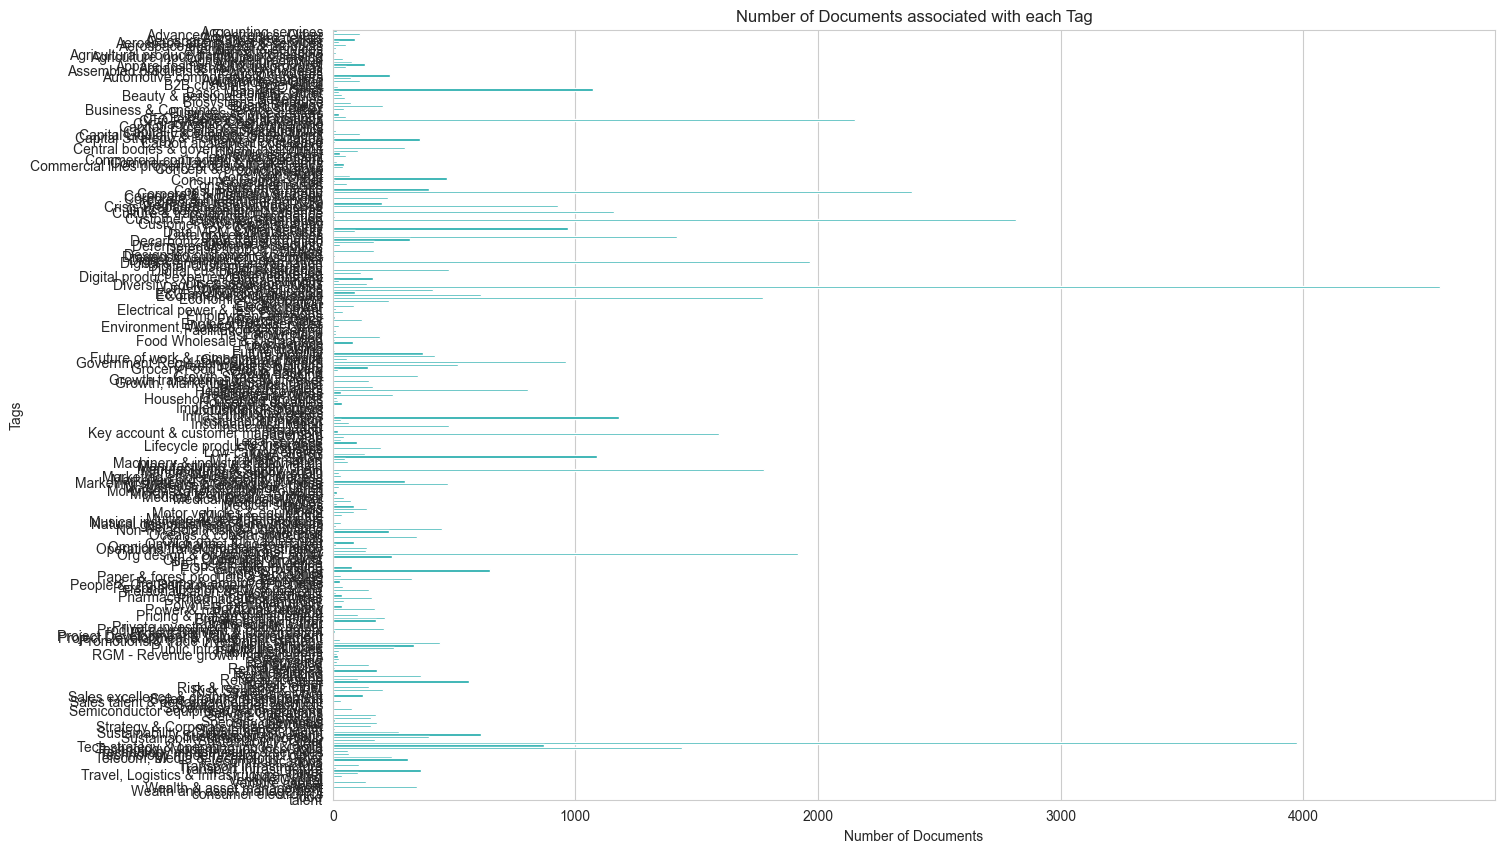

In [12]:
tag_counts = binarizedLabels2.sum(numeric_only=True)

# Plot
plt.figure(figsize=(15, 10))
sns.barplot(x=tag_counts.values, y=tag_counts.index, color='c')
plt.xlabel('Number of Documents')
plt.ylabel('Tags')
plt.title('Number of Documents associated with each Tag')
plt.show()

In [13]:
X_train_2, X_test_2, y_train_2, y_test_2 = train_test_split(dataset['SUMMARY'], binarizedLabels2, test_size=0.1,
                                                            random_state=41)

In [14]:
tfidf = TfidfVectorizer(ngram_range=(1, 2), stop_words='english')
X_train_tfidf_2 = tfidf.fit_transform(X_train_2)
X_test_tfidf_2 = tfidf.transform(X_test_2)
X_train_tfidf_2.shape, X_test_tfidf_2.shape

((18000, 505550), (2000, 505550))

In [ ]:
RFC_2 = OneVsRestClassifier(RandomForestClassifier())
rfc2 = RFC_2.fit(X_train_tfidf_2, y_train_2)

In [ ]:
SGD_2 = OneVsRestClassifier(SGDClassifier())
sgd2 = SGD_2.fit(X_train_tfidf_2, y_train_2)

In [ ]:
LR_2 = OneVsRestClassifier(LogisticRegression(solver='lbfgs'))
lr2 = LR_2.fit(X_train_tfidf_2, y_train_2)

In [15]:
SVC_2 = OneVsRestClassifier(LinearSVC())
svc2 = SVC_2.fit(X_train_tfidf_2, y_train_2)

In [ ]:
XGB_2 = OneVsRestClassifier(XGBClassifier())
xgb2 = XGB_2.fit(X_train_tfidf_2, y_train_2)

In [ ]:
log_clf = LogisticRegression(solver='liblinear')
rnd_clf = RandomForestClassifier(n_estimators=100)
xgb_clf = XGBClassifier(n_estimators=100)
svm_clf = SVC(gamma='auto', probability=True)
voting_clf = VotingClassifier(
    estimators=[('lr', log_clf), ('rf', rnd_clf), ('svc', svm_clf), ('xgb', xgb_clf)], voting='hard')
ovr_voting_2 = OneVsRestClassifier(voting_clf)
ovr_voting_2.fit(X_train_tfidf_2, y_train_2)

In [18]:
models = [
    # ('RandomForest', rfc2),
    # ('SGD', sgd2),
    # ('LogisticRegression', lr2),
    ('LinearSVC', svc2),
    # ('XGBoost', xgb2),
    # ('VotingClassifier', ovr_voting_2)
]

model_comparison = {}

for model_name, model in models:
    predictions = model.predict(X_test_tfidf_2)
    jaccard = jaccard_scr(y_test_2, predictions)

    model_comparison.update({model_name: jaccard})
    joblib.dump(model, model_name + '.joblib')

model_score = pd.DataFrame(model_comparison.items(), columns=['Model', 'Jaccard Score'])

model_score

,Model,Jaccard Score
0,LinearSVC,25.886943


In [ ]:
text = [
    'Understanding mobility’s second great inflection point - Senior partner Asutosh Padhi discusses the technological breakthroughs changing the mobility ecosystem and lays out what the shifts mean for automotive and other industries.']
text = pd.Series(text)
text = text.apply(preprocess_text)
text_tfidf = tfidf.transform(text)
predictions = svc2.predict(text_tfidf)
predicted_labels = mlb.inverse_transform(predictions)
predicted_labels

In [19]:
for i in X_test_2:
    text = pd.Series(i)
    text = text.apply(preprocess_text)
    text_tfidf = tfidf.transform(text)
    predictions = svc2.predict(text_tfidf)
    predicted_labels = mlb.inverse_transform(predictions)
    print(predicted_labels)

[('DnA powered-other topics',)]
[('Green business building', 'Sustainability strategy & portfolio')]
[('Customer experience', 'Marketing strategy-  branding & purpose')]
[('Healthcare payers',)]
[('Digital & analytics transformation',)]
[('Manufacturing & supply chain',)]
[('Venture capital',)]
[()]
[()]
[('Insurance- Other',)]
[()]
[()]
[('Digital & analytics transformation',)]
[()]
[()]
[()]
[('Leadership',)]
[()]
[('Cyber security', 'Insurance- Other')]
[()]
[('Customer experience', 'Digital & analytics transformation')]
[('ECommerce & digital sales',)]
[('Customer experience',)]
[('DnA powered-other topics', 'Manufacturing & supply chain')]
[('Automotive components & suppliers',)]
[('Education',)]
[('Customer experience', 'DnA powered-other topics', 'Insurance- Other', 'Technology Modernization incl Cloud')]
[()]
[()]
[()]
[('Consumer tech & media', 'Customer experience', 'DnA powered-other topics', 'Telecommunications')]
[('Talent',)]
[()]
[()]
[('Data transformation', 'Digital & 